# Identificação de Alvos em Sinais de Radar
## Nome: Rodrigo de Lima Florindo
## Matrícula: 101809

Notas:
- Para executar corretamente este projeto, é necessário baixar manualmente o seguinte conjunto de dados: “https://www.kaggle.com/datasets/iroldan/real-doppler-raddar-database/discussion/568518”, descompactá-lo em uma pasta chamada “dataset” dentro da pasta “Projeto 4”, e excluir manualmente a pasta “data” existente dentro dela.
- A seguir, todas as perguntas do projeto 4 são respondidas nos blocos de texto do tipo markdown.

1. **Leia o trabalho de referência disponível.** (Rodrigo): Li o trabalho disponibilizado. Todos os códigos a seguir se basearam na descrição feita no artigo do dataset e das redes neurais testadas.
2. **Baixe a base de dados que contém as amostras de sinais de radar adquiridas em cenários externos reais. A base apresenta três classes de objetos: drones, carros e pessoas.** (Rodrigo): A base de dados foi manualmente baixada para a pasta deste repositório. É importante comentar que havia uma pasta a mais chamada "data" dentro do dataset, que foi removida manualmente também. A seguir é possível visualizar 8 exemplos de imagens range-Doppler extraídas dos arquivos .csv contidos no dataset de cada classe de objetos, i.e., carros, pessoas e drones. É importante comentar que os autores do artigo destacam que mais de uma imagem foi feita para um mesmo objeto e que as redes neurais testadas utilizam três imagens subsequentes de um mesmo objeto, a fim possibilitar que os modelos de aprendizado testado extraiam características temporais de cada objeto. As 8 imagens a seguir são as primeiras imagens de um dado objeto, extraídas de forma subsequente.

Object counts per class (valid = has 001,002,003):
  Cars: 27 objects
  People: 32 objects
  Drones: 21 objects



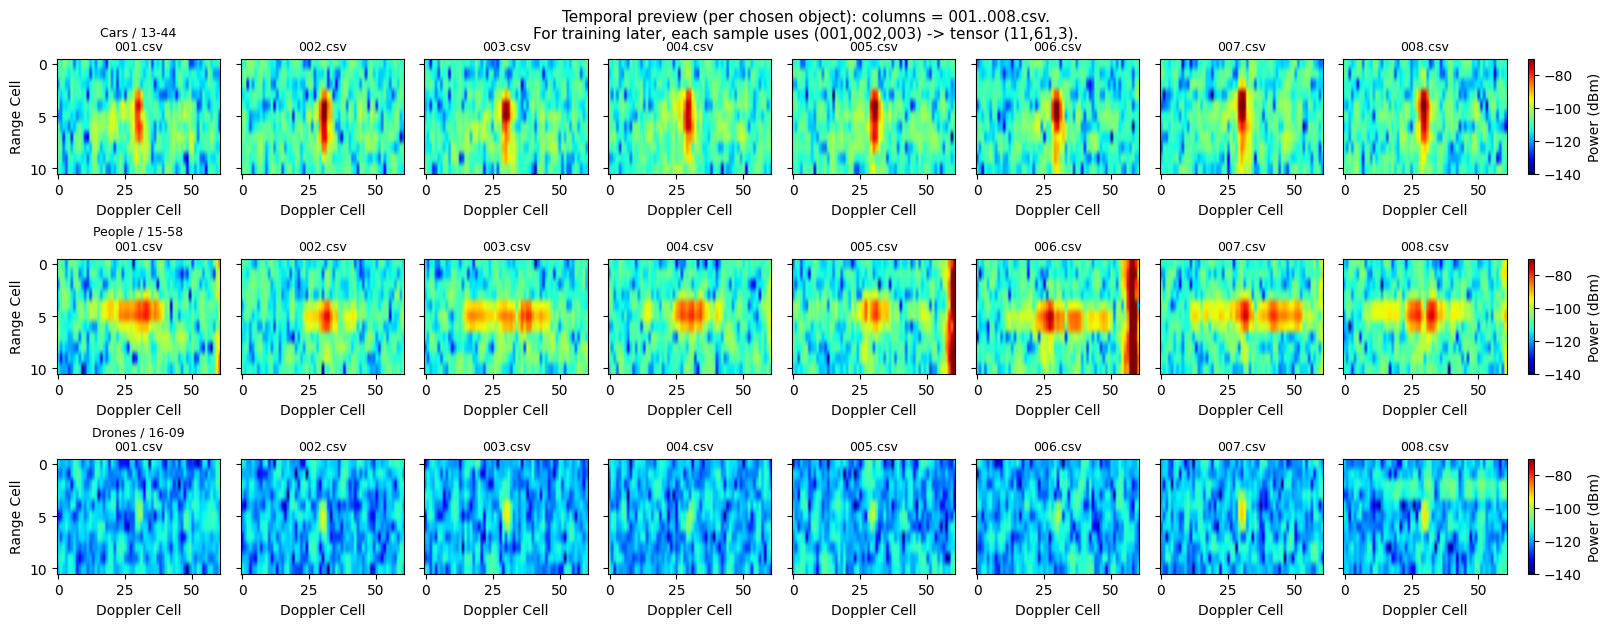

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Basic config
root = Path("dataset")
CLASSES = ["Cars", "People", "Drones"]
FRAMES_TO_SHOW = range(1, 9) # 001..008 for the temporal demo

# Specific objects to preview (one per class)
choices = {
    "Cars":   "13-44",
    "People": "15-58",
    "Drones": "16-09",
}

def load_frame(obj_dir, k):
    """Load a single frame k -> 2D array (for preview)."""
    return pd.read_csv(obj_dir / f"{k:03d}.csv", header=None).to_numpy(dtype=np.float32)

# Build an index of all objects
all_objects = {}
for cls in CLASSES:
    class_dir = root / cls
    objs = []
    if class_dir.exists():
        for p in class_dir.iterdir():
            objs.append(p)
    all_objects[cls] = sorted(objs, key=lambda p: p.name)

# Object count for each class
print("Object counts per class (valid = has 001,002,003):")
for cls in CLASSES:
    print(f"  {cls}: {len(all_objects[cls])} objects")
print()

# 3×8 temporal preview
vmin, vmax = -140, -70
norm = Normalize(vmin=vmin, vmax=vmax)

fig, axes = plt.subplots(
    len(CLASSES), 8, 
    figsize=(16, 6),
    constrained_layout=True, 
    sharey=True
)

for r, cls in enumerate(CLASSES):
    obj_name = choices.get(cls)
    obj_dir = root / cls / obj_name
    row_axes = axes[r]

    for c, k in enumerate(FRAMES_TO_SHOW):
        ax = row_axes[c]
        frame = load_frame(obj_dir, k)
        im = ax.imshow(frame, cmap='jet', norm=norm, aspect='auto')
        title = f"{cls} / {obj_name}\n{k:03d}.csv" if c == 0 else f"{k:03d}.csv"
        ax.set_title(title, fontsize=9)
        ax.set_xlabel('Doppler Cell')

    row_axes[0].set_ylabel('Range Cell')
    # one colorbar per row
    sm = ScalarMappable(norm=norm, cmap='jet'); sm.set_array([])
    fig.colorbar(sm, ax=row_axes, location='right', fraction=0.046, pad=0.01, label='Power (dBm)')

plt.suptitle(
    "Temporal preview (per chosen object): columns = 001..008.csv.\n"
    "For training later, each sample uses (001,002,003) -> tensor (11,61,3).",
    y=1.02, fontsize=11
)
plt.show()


3. **Divida os dados em conjuntos de treinamento, validação e teste.** (Rodrigo): A seguir, realizamos a separação do dataset em grupos de treinamento, validação e de testes, com uma proporção 80%, 10% e 10%, respectivamente. Utilizou-se o objeto `GroupShuffleSplit` do `sklearn`, ao invés do `train_test_split`, pois é um método de separação de dataset, que evita vazamento de informação e métricas superestimadas quando há múltiplas amostras correlacionadas por grupo, algo que o `train_test_split` não assegura, pois divide os exemplos independentemente, podendo separar um mesmo grupo entre treino e teste. 

Ainda mais, tendo em vista o uso de três imagens correlacionadas no tempo pelos autores do artigo, também adotamos a mesma metodologia na separação do dataset. Portanto, foi feito uma janela deslizante entre todas as imagens de cada objeto disponível, a fim de criar várias grupos de 3 imagens concatenadas para o treinamento das redes neurais. Com isso, um grande grupo de dados com correlação no tempo foi usado para gerar os grupos de treinamento, validação e de teste.

In [2]:
from sklearn.model_selection import GroupShuffleSplit

CLASS2IDX = {"Cars": 0, "People": 1, "Drones": 2} # labels
REQUIRED_FOR_SAMPLE = (1, 2, 3) # frames 001,002,003

def load_frame(obj_dir: Path, k: int) -> np.ndarray:
    return pd.read_csv(obj_dir / f"{k:03d}.csv", header=None).to_numpy(dtype=np.float32)

def available_indices(obj_dir: Path) -> list[int]:
    # find all existing k from files like 001.csv, 002.csv, ...
    return sorted(int(p.stem) for p in obj_dir.glob("*.csv") if p.stem.isdigit())

def load_triplet(obj_dir: Path, k0: int) -> np.ndarray:
    # stack (k0, k0+1, k0+2) -> (11, 61, 3)
    a = load_frame(obj_dir, k0)
    b = load_frame(obj_dir, k0 + 1)
    c = load_frame(obj_dir, k0 + 2)
    return np.stack([a, b, c], axis=-1).astype(np.float32)

# Build all windows
X_list, y_list, d_list, grp_list = [], [], [], []
for cls in CLASSES:
    label = CLASS2IDX[cls]
    for obj_dir in all_objects[cls]:
        obj_name = obj_dir.name
        ks = available_indices(obj_dir)
        # all contiguous triplets present: (k, k+1, k+2) must exist
        for k0 in ks:
            if (k0 + 1 in ks) and (k0 + 2 in ks):
                X_list.append(load_triplet(obj_dir, k0)) # (11,61,3)
                y_list.append(label)
                d_list.append(f"{cls}/{obj_name}:{k0:03d}-{k0+2:03d}")
                grp_list.append(f"{cls}/{obj_name}") # group by object

X = np.stack(X_list) # (N_samples, 11, 61, 3)
y = np.array(y_list, dtype=np.int64)
d = np.array(d_list)
groups = np.array(grp_list)

print("Built (with sliding windows):", X.shape, "samples")

# Pick TRAIN objects: 80% train, 20% remainder (val+test pool)
gss1 = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
train_idx, rest_idx = next(gss1.split(X, y, groups=groups))

# From the 20% remainder, split half/half: 10% val, 10% test
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
val_rel, test_rel = next(gss2.split(X[rest_idx], y[rest_idx], groups=groups[rest_idx]))

val_idx  = rest_idx[val_rel]
test_idx = rest_idx[test_rel]

# Slices
X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

Built (with sliding windows): (17221, 11, 61, 3) samples
Shapes: (13529, 11, 61, 3) (1773, 11, 61, 3) (1919, 11, 61, 3)


4. **Implemente uma CNN capaz de processar os dados de radar de range-Doppler brutos e realizar a classificação dos objetos. Configure a arquitetura da CNN e otimize os hiperparâmetros para obter o melhor desempenho possível.** (Rodrigo): No bloco de código a seguir, criou-se uma topologia de CNN baseada na figura 10 do artigo com o Keras e disponibilizou-se os sumários dos modelos. A quantidade de parâmetros da topologia de rede apresentada na Figura 10 resulta em 1.087.552 parâmetros, conforme mostrado abaixo. No entanto, na Tabela 5, os autores descrevem que a DopplerNet possui 3.818.755 parâmetros. Acredito que eles não apresentaram a estrutura realmente adotada da DopplerNet neste artigo. Contudo, nos resultados adiante neste relatório podemos ver que a performance deste modelo mais simples da figura 10 funciona com uma acurácia global acima de 96%, mesmo sendo uma rede com menos parâmetros do que a que foi reportada na tabela 5 do artigo.

In [3]:
import tensorflow as tf
import keras

BATCH = 64
# AUTOTUNE was used to configure  prefetch for training the network faster.
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = len(CLASSES)

def make_ds(X, y, training=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(len(X), seed=42)
    return ds.batch(BATCH).prefetch(AUTOTUNE)

# One-hot the labels
y_train_oh = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val_oh   = keras.utils.to_categorical(y_val,   NUM_CLASSES)
y_test_oh  = keras.utils.to_categorical(y_test,  NUM_CLASSES)

# Rebuild datasets using one-hot labels
train_ds = make_ds(X_train, y_train_oh, training=True)
val_ds   = make_ds(X_val, y_val_oh)
test_ds  = make_ds(X_test, y_test_oh)

norm = keras.layers.Normalization() # zero-mean / unit-std
norm.adapt(X_train) # fit on TRAIN only

inputs = keras.Input(shape=(11, 61, 3), name="rd_input")
x = norm(inputs)
x = keras.layers.Conv2D(32, (3, 3), padding="valid", activation="relu")(x) 
x = keras.layers.Flatten()(x) 
x = keras.layers.Dense(64, activation="relu")(x) 
x = keras.layers.Dense(64,  activation="relu")(x) 
x = keras.layers.Dense(64,  activation="relu")(x) 
outputs = keras.layers.Dense(3, activation="softmax", name="probs")(x) # 3 classes

DopplerNet = keras.Model(inputs, outputs, name="DopplerNet_like")
DopplerNet.summary()

DopplerNet.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
)


2025-10-15 13:54:16.177697: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-15 13:54:16.199354: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 13:54:16.770000: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 13:54:18.803886: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

Model: "DopplerNet_like"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rd_input (InputLayer)           │ (None, 11, 61, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 11, 61, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 9, 59, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,087,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ probs (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,096,970 (4.18 MB)

 Trainable params: 1,096,963 (4.18 MB)

 Non-trainable params: 7 (32.00 B)

5. **Avalie o desempenho do modelo treinado utilizando o conjunto de validação.** (Rodrigo): A seguir, treina-se a CNN proposta pelo artigo usando 25 épocas e uma taxa de aprendizado de 1e-4. É importante comentar que outras taxas de aprendizado foram testadas, bem como o uso de dropout e de técnicas de early stop para evitar overfitting. Contudo, as análises a seguir mantêm a mesma metodologia utilizada no artigo. Abaixo é possível observar as curvas das funções de custo e das acurácias obtidas para o grupo de dados de treinamento e de validação.
6. (também inclui o item 7) **Analise as métricas de desempenho, como acurácia, precisão, recall e F1-score, para cada classe (drone, carro e pessoa). Visualize as previsões do modelo em amostras de dados de teste para entender melhor suas capacidades e limitações.** (Rodrigo): Em seguida, Mostra-se também as métricas acurácia, recall, f1-score e suporte, bem como a matriz de confusão para o grupo de dados de teste. Os resultados indicam que todas as métricas obtidas apresentam uma performance acima de 96%. Portanto, a topologia de CNN proposta pelo artigo apresenta um grau elevado precisão para a classificação das imagens range-Doppler de radar. Além disso, pelos gráficos das curvas de custo e de acurácia, é possível identificar que na sétima época a acurácia do grupo de treinamento já chegou em 100%, enquanto o grupo de validação tem um plateau um pouco inferior ao grupo de treinamento, o que pode indicar um leve overfitting.
8. **Compare os resultados com os obtidos pelo sistema proposto no trabalho original para avaliar a eficácia do modelo em relação à referência.** (Rodrigo): O trabalho reporta na tabela 5 uma acurácia de 99.48%, enquanto a acurácia global obtida aqui foi em torno de 96%. Isso pode estar relacionado com o fato de que a rede DopplerNet usada pelo artigo para obter este altíssimo grau de precisão contêm mais parâmetros do que a usada aqui. Contudo, ressalta-se novamente que a topologia proposta na figura 10 não corresponde à mesma usada para obter o resultado da DopplerNet na tabela 5, tendo em vista que a topologia da figura 10 tem 1.096.963 parâmetros, enquanto a DopplerNet descrita na tabela 5 possui 3.818.755 parâmetros.

Epoch 1/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - acc: 0.8692 - loss: 0.3450 - val_acc: 0.9509 - val_loss: 0.1948 - learning_rate: 1.0000e-04
Epoch 2/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.9684 - loss: 0.1084 - val_acc: 0.9509 - val_loss: 0.1369 - learning_rate: 1.0000e-04
Epoch 3/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - acc: 0.9815 - loss: 0.0676 - val_acc: 0.9549 - val_loss: 0.1187 - learning_rate: 1.0000e-04
Epoch 4/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.9880 - loss: 0.0452 - val_acc: 0.9752 - val_loss: 0.0712 - learning_rate: 1.0000e-04
Epoch 5/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - acc: 0.9934 - loss: 0.0261 - val_acc: 0.9825 - val_loss: 0.0573 - learning_rate: 1.0000e-04
Epoch 6/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - acc: 0.9959 - loss: 0.0184 - val_acc: 0.9831 - val_loss: 0.0493 - learning_rate: 1.0000e-04
Epoch 7/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - acc: 0.9976 - loss: 0.0113 - val_acc: 0.9712 - val_loss: 0.0788

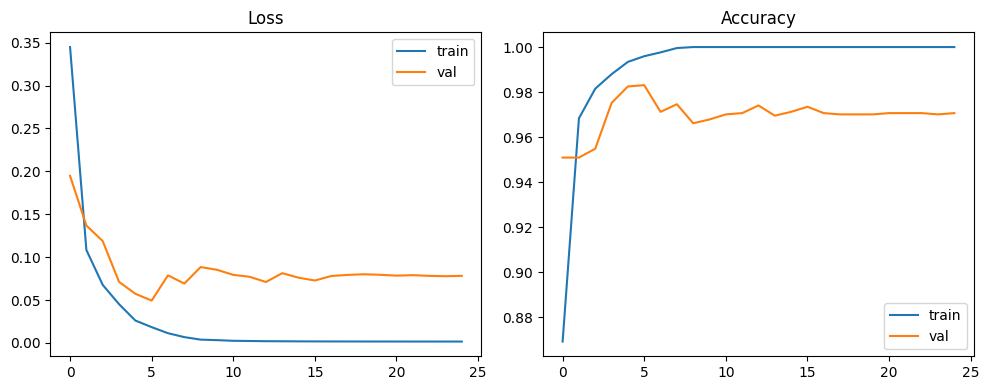


Keras test metrics: {'loss': 0.125055730342865, 'compile_metrics': 0.9619593620300293}

Classification report:
              precision    recall  f1-score   support

        Cars     0.9757    0.9488    0.9620       761
      People     0.9627    0.9945    0.9783       545
      Drones     0.9448    0.9494    0.9471       613

    accuracy                         0.9620      1919
   macro avg     0.9611    0.9642    0.9625      1919
weighted avg     0.9621    0.9620    0.9619      1919

Confusion matrix:
 [[722   6  33]
 [  2 542   1]
 [ 16  15 582]]


In [4]:
from sklearn.metrics import classification_report, confusion_matrix

EPOCHS = 25

# --- Train ---
cbs = [
    #keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1),
    keras.callbacks.ModelCheckpoint("dopplernet_best.keras", save_best_only=True),
]

history = DopplerNet.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cbs, verbose=1)

# quick curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history.history["loss"], label="train"); plt.plot(history.history["val_loss"], label="val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history.history["acc"], label="train");  plt.plot(history.history["val_acc"], label="val");  plt.title("Accuracy"); plt.legend()
plt.tight_layout(); plt.show()

# ----- Evaluate on the untouched test set -----
print("\nKeras test metrics:", dict(zip(DopplerNet.metrics_names, DopplerNet.evaluate(test_ds, verbose=0))))

# sklearn report
y_true = y_test.astype(int)
y_pred = DopplerNet.predict(test_ds, verbose=0).argmax(axis=1)
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

9. **Escolha uma das arquiteturas clássicas de CNN, treinadas com a Imagenet. Adapte os dados de entrada, se necessário, e verifique o desempenho obtido na classificação utilizando este novo modelo. Compare com o modelo encontrado inicialmente, considerando custo computacional e desempenho.** (Rodrigo): Escolheu-se a rede MobileNetV2, que foi uma das utilizadas na tabela 5 do artigo para comparar com a rede DopplerNet proposta pelo artigo. No código a seguir, importa-se a MobileNetV2 do Keras, configura-se para o seu treinamento ser congelado, e uma camada de ZeroPadding e de normalização é usada para garantir que o formato dos dados de entrada sejam adequados para o uso da MobileNetV2. Ainda mais, usa-se uma rede MLP com três camadas densas de 64 neurônios e função de ativação ReLu, seguida de uma camada densa com 3 neurônios e função de ativação softmax. Configura-se também a taxa de aprendizado deste algoritmo de transfer-learning para 1e-4. 

No bloco de código adiante, temos também o treinamento do MLP em cascata com a rede MobileNetV2. Os gráficos da função de custo e da acurácia obtida estão disponíveis para visualização, bem como as métricas de acurácia, recall, f1-score e suporte e a matriz de confusão para o grupo de dados de teste. As funções de custo indicam que a rede ficou precisa à um mínimo local na otimização, de tal maneira que a função de custo do grupo de dados de treinamento no plateau não chegou próxima de zero, como foi observado no caso da rede CNN. A acurácia do grupo de dados do treinamento chegou próxima à 90%, enquanto a acurácia do grupo de dados de validação fica em torno de 88% no plateau. Ainda mais, os grupo de testes mostra que a acurácia global ficou abaixo de 75%, o que indica uma performance bem pior se comparada a CNN analisada anteriormente, e considerávelmente pior que a performance reportada na tabela 5 do artigo para a rede MobileNetV2. Contudo, é importante ressaltar que o artigo não detalha como a rede MLP em cascata com a MobileNetV2 foi configurada, o que impossibilita reproduzir com precisão os resultados obtidos. Além disso, o número de parâmetros da rede analisada aqui foi de 2.348.483, com 90.499 parâmetros treináveis da rede MLP e 2.257.984 parâmetros não treináveis da rede MobileNetV2, enquanto a rede MobileNetV2 reportada na tabela 5 do artigo possui um total de 3.325.043 de parâmetros. É importante comentar que a etapa de fine-tuning, em que os pesos da MobileNetV2 são descongelados e então treina-se toda a rede composta pela MobileNetV2 e o MLP com um learning rate baixíssimo, não foi realizada aqui. É importante comentar também que o custo computacional de treinamento deste modelo foi considerávelmente maior que a CNN analisada anteriormente.

In [7]:
base = keras.applications.MobileNetV2(include_top=False, weights="imagenet", pooling="avg")  # accepts ≥32x32
base.trainable = False

# External input is 11x61x3
inputs = keras.Input(shape=(11, 61, 3), name="rd_input")

# Pad to 32x64 so the backbone's striding doesn't collapse the feature map
x = keras.layers.ZeroPadding2D(((10, 11), (1, 2)))(inputs)  # -> (32, 64, 3)

# keep values within the physical range so outputs stay in [-1, 1]
x = keras.layers.Lambda(lambda t: tf.clip_by_value(t, vmin, vmax))(inputs)

# Map [vmin, vmax] -> [-1, 1] in ONE step:
scale  = 2.0 / (vmax - vmin)             # = 2 / 70 ≈ 0.0285714
offset = -(vmax + vmin) / (vmax - vmin)   # = -(-210) / 70 = 3.0
x = keras.layers.Rescaling(scale, offset=offset)(x)
x = keras.layers.Resizing(96, 128, interpolation="bilinear")(x)  # 96x128 is safe (height >= 96)

# Run the frozen backbone
x = base(x, training=False)

# Small MLP for classifying the radar signals
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
outputs = keras.layers.Dense(3, activation="softmax", name="probs")(x)

AdaptedMobileNetV2 = keras.Model(inputs, outputs, name="MobileNetV2_padded_head")
AdaptedMobileNetV2.summary()

AdaptedMobileNetV2.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",                 # one-hot labels
    metrics=[keras.metrics.CategoricalAccuracy(name="acc")]
)

/tmp/ipykernel_2796/2091771938.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = keras.applications.MobileNetV2(include_top=False, weights="imagenet", pooling="avg")  # accepts ≥32x32


Model: "MobileNetV2_padded_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rd_input (InputLayer)           │ (None, 11, 61, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 11, 61, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 11, 61, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 96, 128, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ probs (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,348,483 (8.96 MB)

 Trainable params: 90,499 (353.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 56s 249ms/step - acc: 0.7506 - loss: 0.5828 - val_acc: 0.8911 - val_loss: 0.4022 - learning_rate: 1.0000e-04
Epoch 2/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 50s 235ms/step - acc: 0.8447 - loss: 0.3692 - val_acc: 0.8703 - val_loss: 0.4169 - learning_rate: 1.0000e-04
Epoch 3/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 50s 234ms/step - acc: 0.8573 - loss: 0.3295 - val_acc: 0.8838 - val_loss: 0.3655 - learning_rate: 1.0000e-04
Epoch 4/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 54s 253ms/step - acc: 0.8688 - loss: 0.3053 - val_acc: 0.8466 - val_loss: 0.4006 - learning_rate: 1.0000e-04
Epoch 5/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 47s 223ms/step - acc: 0.8764 - loss: 0.2891 - val_acc: 0.9272 - val_loss: 0.2806 - learning_rate: 1.0000e-04
Epoch 6/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 45s 213ms/step - acc: 0.8810 - loss: 0.2764 - val_acc: 0.8900 - val_loss: 0.3362 - learning_rate: 1.0000e-04
Epoch 7/25
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - acc: 0.8875 - loss: 0.2644
Epoch 7: ReduceLROnPlat

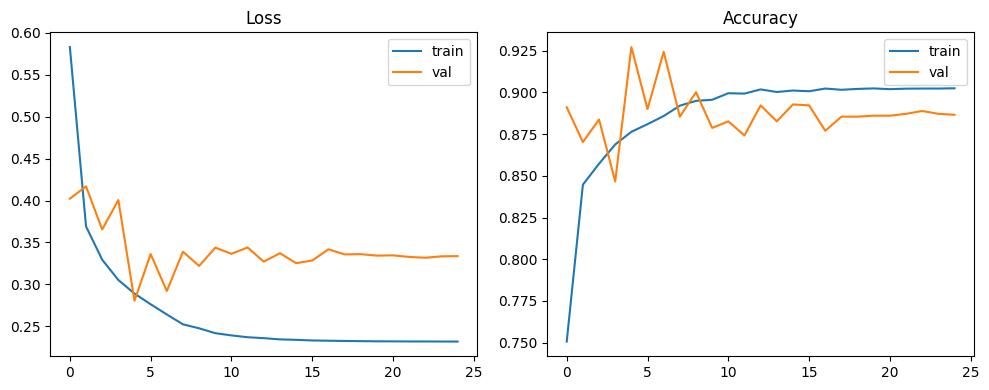


Keras test metrics: {'loss': 0.7122622728347778, 'compile_metrics': 0.743095338344574}

Classification report:
              precision    recall  f1-score   support

        Cars     0.8350    0.7845    0.8089       761
      People     0.7171    1.0000    0.8352       545
      Drones     0.6396    0.4633    0.5374       613

    accuracy                         0.7431      1919
   macro avg     0.7306    0.7493    0.7272      1919
weighted avg     0.7391    0.7431    0.7297      1919

Confusion matrix:
 [[597   4 160]
 [  0 545   0]
 [118 211 284]]


In [8]:
# --- Train ---
cbs = [
    #keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1),
    keras.callbacks.ModelCheckpoint("mnetv2_rd_best.keras", save_best_only=True),
]

history = AdaptedMobileNetV2.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cbs, verbose=1)

# quick curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history.history["loss"], label="train"); plt.plot(history.history["val_loss"], label="val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history.history["acc"], label="train");  plt.plot(history.history["val_acc"], label="val");  plt.title("Accuracy"); plt.legend()
plt.tight_layout(); plt.show()

# ----- Evaluate on the untouched test set -----
print("\nKeras test metrics:", dict(zip(AdaptedMobileNetV2.metrics_names, AdaptedMobileNetV2.evaluate(test_ds, verbose=0))))

# sklearn report
y_true = y_test.astype(int)
y_pred = AdaptedMobileNetV2.predict(test_ds, verbose=0).argmax(axis=1)
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))